In [1]:
import pandas as pd
import ast
import numpy as np
from functools import partial
from tensorflow.keras.callbacks import EarlyStopping 
import tensorflow as tf
import keras
import random
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import LSTM
from keras.layers import Reshape

from keras.layers import Lambda
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

2023-10-05 00:21:56.078522: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Function to load and preprocess the data
Window size 100ms is chosen 

In [2]:
csv_file="data/avg_padded_truncated_mfcc_100ms.csv"      
data = pd.read_csv(csv_file)
num_mfccs = int(data['num_mfcc_values'][0])
mfcc_columns = [f'mfcc_{i}' for i in range(1, 14)]
X = np.array([data[mfcc_column].apply(eval).tolist() for mfcc_column in mfcc_columns])
# Reshape X to (number of instances, num_mfccs, 13, 1)

In [3]:
X = np.array([data[mfcc_column].apply(eval).tolist() for mfcc_column in mfcc_columns])

In [4]:
X = X.transpose(1, 0, 2)  # Transpose to (13, number_of_samples, reference_length)
X = X.reshape(-1, num_mfccs * 13) 
scaler = StandardScaler()
X= scaler.fit_transform(X)
X = X.reshape(-1, num_mfccs, 13)
y = data['label']

In [5]:
X.shape

(38392, 62, 13)

In [6]:
y.shape

(38392,)

In [7]:
def split_data(no_class, X,y):
    if no_class==2: # binary classification
        label_mapping = {'N': 0, 'S1': 1, 'S2':1, 'S3':1}
    else: 
        label_mapping = {'N': 0, 'S1': 1, 'S2':2, 'S3':3}
    y= y.replace(label_mapping)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val= train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
    return X_train, X_test, X_val, y_train, y_test, y_val 

## Function to create and fit CNN model

In [8]:
def create_fit_cnn(no_filters, kernel_sizes, activation, wht_init, lr, dr):
    
    if no_class==2: # binary classification
        units=1 # no of neurons in output layer
        output_activation='sigmoid' #sigmoid activation for binary classification
        loss='binary_crossentropy'
    else: 
        units=4
        output_activation='softmax' #Softmax activation for 4 class
        loss='sparse_categorical_crossentropy'
        
    DefaultConv2D = partial(layers.Conv2D, kernel_size=kernel_sizes, activation=activation, padding='same')
    cnn_model = models.Sequential([
        DefaultConv2D(filters=no_filters, kernel_size=kernel_sizes, input_shape=(num_mfccs, 13, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=2),

        DefaultConv2D(filters=no_filters*2),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=2),
        
        layers.Flatten(),
        layers.Dropout(dr),
        
        layers.Dense(units=128, activation=activation, kernel_initializer=wht_init),
        layers.BatchNormalization(),

        layers.Dense(units=units, activation=output_activation)
    ])
    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    # Compile the model with the given learning rate schedule
    cnn_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler_cb=keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    history = cnn_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                        callbacks=[early_stopping, lr_scheduler_cb])
    return cnn_model, history

## Function to create CNN+LSTM model

In [9]:
def create_fit_cnn_lstm(no_filters, kernel_sizes, activation, wht_init, lr, dr):
    if no_class == 2:  # binary classification
        units = 1  # number of neurons in the output layer
        output_activation = 'sigmoid'  # sigmoid activation for binary classification
        loss = 'binary_crossentropy'
    else:
        units = 4
        output_activation = 'softmax'  # softmax activation for multi-class
        loss = 'sparse_categorical_crossentropy'

    DefaultConv2D = partial(Conv2D, kernel_size=kernel_sizes, activation=activation, padding='same')
    cnn_lstm_model = Sequential([
        DefaultConv2D(filters=no_filters, kernel_size=kernel_sizes, input_shape=(num_mfccs, 13, 1)),
        #BatchNormalization(),
        #MaxPooling2D(pool_size=2),
        
        # LSTM layers for sequence modeling
        Reshape(target_shape=(num_mfccs, 13 * no_filters)),
        LSTM(units=no_filters, return_sequences=True),
        LSTM(units=no_filters),

        Flatten(),
        Dropout(dr),
        Dense(units=128, activation=activation, kernel_initializer=wht_init),
        BatchNormalization(),
        Dense(units=units, activation=output_activation)
    ])

    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    
    cnn_lstm_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler_cb = ReduceLROnPlateau(factor=0.5, patience=5)

    history = cnn_lstm_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                                 callbacks=[early_stopping, lr_scheduler_cb])

    return cnn_lstm_model, history


## Function to plot learning curve

In [10]:
#function to plot accuracy, loss and learning rate
def plot_loss_accuracy(history):
    # Create a 1x3 grid of subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    # Plot Accuracy Curve
    axes[0].plot(history.history['accuracy'], 'r-', label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], 'b-', label='Validation Accuracy')
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Accuracy Curve")
    axes[0].grid(True)
    axes[0].legend(loc="lower right")

    # Plot Loss Curve
    axes[1].plot(history.history['loss'], 'r-', label='Training Loss')
    axes[1].plot(history.history['val_loss'], 'b-', label='Validation Loss')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Loss Curve")
    axes[1].grid(True)
    axes[1].legend(loc="upper right")

    # Adjust spacing between subplots
    plt.tight_layout()
    # Show the combined plot
    plt.show()

## Function to print confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def print_conf_matrix(y_train, y_train_pred, y_test, y_test_pred, class_names):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=class_names).im_.colorbar.remove()
    axs[0].set_title("Train set ")
    axs[0].tick_params(axis='x', labelrotation=90)
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=class_names).im_.colorbar.remove()
    axs[1].set_title("Test set ")
    axs[1].tick_params(axis='x', labelrotation=90)
    plt.show()

# Hyper parameter finetuning


In [12]:
no_class=4
X_train, X_test, X_val, y_train, y_test, y_val = split_data(no_class,X,y)

In [13]:
X_train.shape

(24570, 62, 13)

In [14]:
X_val.shape

(6143, 62, 13)

In [15]:
from itertools import product

# Define a list of hyperparameter combinations to search
param_grid = {
    'no_filters': [32, 64],
    'kernel_sizes': [3, 5], 
    'wht_init': ["glorot_normal", "he_normal"],
    'dr': [0.2, 0.3],
    'lr': [0.01, 0.001],
    'activation': ['relu', 'selu'],
    # Add other hyperparameters here
}

best_score = 0
best_params = {}
count = 0

# Loop through hyperparameter combinations
for params in product(*param_grid.values()):
    count += 1
    no_filters, kernel_sizes, wht_init, dr, lr, activation = params
    print(f"Training model {count} with no_filters={no_filters}, kernel_sizes={kernel_sizes}, wht_init={wht_init}, dropout rate={dr}, learning rate={lr}, activation={activation}")
    model, history = create_fit_cnn(
        no_filters=no_filters,
        kernel_sizes=kernel_sizes,
        wht_init=wht_init,
        dr=dr,
        lr=lr,
        activation=activation
    )
    score = model.evaluate(X_val, y_val, verbose=0)[1]  # Get accuracy as the score
    
    # Check if this model's score is better than the previous best
    if score > best_score:
        best_score = score
        best_params = {
            'no_filters': no_filters,
            'kernel_sizes': kernel_sizes,
            'wht_init': wht_init,
            'dr': dr,
            'lr': lr,
            'activation': activation
        }

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Training model 1 with no_filters=32, kernel_sizes=3, wht_init=glorot_normal, dropout rate=0.2, learning rate=0.01, activation=relu
Epoch 1/100
768/768 [==============================] - 14s 18ms/step - loss: 0.2074 - accuracy: 0.9267 - val_loss: 0.1193 - val_accuracy: 0.9539 - lr: 0.0100
Epoch 2/100
768/768 [==============================] - 15s 19ms/step - loss: 0.1242 - accuracy: 0.9556 - val_loss: 0.1099 - val_accuracy: 0.9583 - lr: 0.0100
Epoch 3/100
768/768 [==============================] - 16s 21ms/step - loss: 0.1051 - accuracy: 0.9604 - val_loss: 0.0978 - val_accuracy: 0.9639 - lr: 0.0100
Epoch 4/100
768/768 [==============================] - 18s 24ms/step - loss: 0.0910 - accuracy: 0.9654 - val_loss: 0.1016 - val_accuracy: 0.9650 - lr: 0.0100
Epoch 5/100
768/768 [==============================] - 24s 31ms/step - loss: 0.0858 - accuracy: 0.9678 - val_loss: 0.0981 - val_accuracy: 0.9650 - lr: 0.0100
Epoch 6/100
768/768 [==============================] - 23s 30ms/step - loss: 0.

768/768 [==============================] - 34s 44ms/step - loss: 0.2851 - accuracy: 0.9072 - val_loss: 0.1480 - val_accuracy: 0.9505 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 32s 42ms/step - loss: 0.1667 - accuracy: 0.9431 - val_loss: 0.1333 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 3/100
768/768 [==============================] - 30s 39ms/step - loss: 0.1447 - accuracy: 0.9483 - val_loss: 0.1171 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 4/100
768/768 [==============================] - 29s 38ms/step - loss: 0.1272 - accuracy: 0.9541 - val_loss: 0.1085 - val_accuracy: 0.9608 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 28s 37ms/step - loss: 0.1186 - accuracy: 0.9572 - val_loss: 0.1104 - val_accuracy: 0.9603 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 28s 36ms/step - loss: 0.1058 - accuracy: 0.9611 - val_loss: 0.1013 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 7/100
768/768 [==============================] - 29s 37ms/

Epoch 14/100
768/768 [==============================] - 28s 37ms/step - loss: 0.0463 - accuracy: 0.9836 - val_loss: 0.1050 - val_accuracy: 0.9622 - lr: 0.0100
Epoch 15/100
768/768 [==============================] - 28s 37ms/step - loss: 0.0328 - accuracy: 0.9879 - val_loss: 0.1035 - val_accuracy: 0.9674 - lr: 0.0050
Epoch 16/100
768/768 [==============================] - 29s 38ms/step - loss: 0.0255 - accuracy: 0.9910 - val_loss: 0.1065 - val_accuracy: 0.9665 - lr: 0.0050
Epoch 17/100
768/768 [==============================] - 27s 36ms/step - loss: 0.0253 - accuracy: 0.9908 - val_loss: 0.1110 - val_accuracy: 0.9648 - lr: 0.0050
Epoch 18/100
768/768 [==============================] - 28s 36ms/step - loss: 0.0219 - accuracy: 0.9920 - val_loss: 0.1223 - val_accuracy: 0.9643 - lr: 0.0050
Epoch 19/100
768/768 [==============================] - 28s 37ms/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.1223 - val_accuracy: 0.9643 - lr: 0.0050
Training model 7 with no_filters=32, kernel_si

Epoch 24/100
768/768 [==============================] - 31s 40ms/step - loss: 0.0619 - accuracy: 0.9790 - val_loss: 0.0965 - val_accuracy: 0.9678 - lr: 5.0000e-04
Epoch 25/100
768/768 [==============================] - 28s 37ms/step - loss: 0.0568 - accuracy: 0.9791 - val_loss: 0.0983 - val_accuracy: 0.9673 - lr: 5.0000e-04
Epoch 26/100
768/768 [==============================] - 30s 38ms/step - loss: 0.0581 - accuracy: 0.9783 - val_loss: 0.1004 - val_accuracy: 0.9653 - lr: 5.0000e-04
Epoch 27/100
768/768 [==============================] - 30s 40ms/step - loss: 0.0574 - accuracy: 0.9796 - val_loss: 0.0955 - val_accuracy: 0.9692 - lr: 5.0000e-04
Epoch 28/100
768/768 [==============================] - 31s 40ms/step - loss: 0.0537 - accuracy: 0.9810 - val_loss: 0.0985 - val_accuracy: 0.9666 - lr: 2.5000e-04
Epoch 29/100
768/768 [==============================] - 33s 43ms/step - loss: 0.0522 - accuracy: 0.9810 - val_loss: 0.0952 - val_accuracy: 0.9671 - lr: 2.5000e-04
Epoch 30/100
768/768 [

768/768 [==============================] - 33s 42ms/step - loss: 0.1084 - accuracy: 0.9612 - val_loss: 0.1089 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 33s 43ms/step - loss: 0.1002 - accuracy: 0.9637 - val_loss: 0.1083 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 7/100
768/768 [==============================] - 33s 42ms/step - loss: 0.0952 - accuracy: 0.9655 - val_loss: 0.1016 - val_accuracy: 0.9648 - lr: 0.0010
Epoch 8/100
768/768 [==============================] - 33s 42ms/step - loss: 0.0869 - accuracy: 0.9684 - val_loss: 0.1024 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 9/100
768/768 [==============================] - 33s 43ms/step - loss: 0.0778 - accuracy: 0.9718 - val_loss: 0.1025 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 10/100
768/768 [==============================] - 32s 42ms/step - loss: 0.0747 - accuracy: 0.9722 - val_loss: 0.1046 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 11/100
768/768 [==============================] - 32s 42m

Epoch 14/100
768/768 [==============================] - 33s 42ms/step - loss: 0.0428 - accuracy: 0.9843 - val_loss: 0.1076 - val_accuracy: 0.9683 - lr: 0.0100
Epoch 15/100
768/768 [==============================] - 32s 42ms/step - loss: 0.0322 - accuracy: 0.9884 - val_loss: 0.0999 - val_accuracy: 0.9689 - lr: 0.0050
Epoch 16/100
768/768 [==============================] - 33s 42ms/step - loss: 0.0264 - accuracy: 0.9908 - val_loss: 0.1094 - val_accuracy: 0.9683 - lr: 0.0050
Epoch 17/100
768/768 [==============================] - 32s 42ms/step - loss: 0.0223 - accuracy: 0.9919 - val_loss: 0.1033 - val_accuracy: 0.9689 - lr: 0.0050
Epoch 18/100
768/768 [==============================] - 31s 41ms/step - loss: 0.0211 - accuracy: 0.9928 - val_loss: 0.1178 - val_accuracy: 0.9684 - lr: 0.0050
Epoch 19/100
768/768 [==============================] - 31s 40ms/step - loss: 0.0199 - accuracy: 0.9928 - val_loss: 0.1134 - val_accuracy: 0.9699 - lr: 0.0050
Training model 14 with no_filters=32, kernel_s

768/768 [==============================] - 32s 42ms/step - loss: 0.1404 - accuracy: 0.9511 - val_loss: 0.1132 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 33s 43ms/step - loss: 0.1329 - accuracy: 0.9514 - val_loss: 0.1199 - val_accuracy: 0.9549 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 32s 41ms/step - loss: 0.1205 - accuracy: 0.9546 - val_loss: 0.1040 - val_accuracy: 0.9632 - lr: 0.0010
Epoch 7/100
768/768 [==============================] - 29s 38ms/step - loss: 0.1164 - accuracy: 0.9586 - val_loss: 0.0991 - val_accuracy: 0.9632 - lr: 0.0010
Epoch 8/100
768/768 [==============================] - 28s 37ms/step - loss: 0.1106 - accuracy: 0.9597 - val_loss: 0.1046 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 9/100
768/768 [==============================] - 31s 40ms/step - loss: 0.1070 - accuracy: 0.9613 - val_loss: 0.0993 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 10/100
768/768 [==============================] - 31s 41ms

768/768 [==============================] - 34s 44ms/step - loss: 0.2041 - accuracy: 0.9277 - val_loss: 0.1282 - val_accuracy: 0.9518 - lr: 0.0100
Epoch 2/100
768/768 [==============================] - 34s 44ms/step - loss: 0.1265 - accuracy: 0.9530 - val_loss: 0.1389 - val_accuracy: 0.9497 - lr: 0.0100
Epoch 3/100
768/768 [==============================] - 33s 44ms/step - loss: 0.1078 - accuracy: 0.9603 - val_loss: 0.0973 - val_accuracy: 0.9661 - lr: 0.0100
Epoch 4/100
768/768 [==============================] - 34s 45ms/step - loss: 0.0992 - accuracy: 0.9630 - val_loss: 0.1100 - val_accuracy: 0.9634 - lr: 0.0100
Epoch 5/100
768/768 [==============================] - 34s 44ms/step - loss: 0.0868 - accuracy: 0.9679 - val_loss: 0.0977 - val_accuracy: 0.9643 - lr: 0.0100
Epoch 6/100
768/768 [==============================] - 34s 45ms/step - loss: 0.0780 - accuracy: 0.9700 - val_loss: 0.1067 - val_accuracy: 0.9621 - lr: 0.0100
Epoch 7/100
768/768 [==============================] - 34s 45ms/

768/768 [==============================] - 37s 48ms/step - loss: 0.2031 - accuracy: 0.9291 - val_loss: 0.1159 - val_accuracy: 0.9603 - lr: 0.0100
Epoch 2/100
768/768 [==============================] - 36s 47ms/step - loss: 0.1303 - accuracy: 0.9512 - val_loss: 0.1056 - val_accuracy: 0.9600 - lr: 0.0100
Epoch 3/100
768/768 [==============================] - 36s 47ms/step - loss: 0.1102 - accuracy: 0.9603 - val_loss: 0.0937 - val_accuracy: 0.9666 - lr: 0.0100
Epoch 4/100
768/768 [==============================] - 36s 47ms/step - loss: 0.0987 - accuracy: 0.9634 - val_loss: 0.3178 - val_accuracy: 0.8984 - lr: 0.0100
Epoch 5/100
768/768 [==============================] - 36s 47ms/step - loss: 0.0916 - accuracy: 0.9662 - val_loss: 0.0898 - val_accuracy: 0.9679 - lr: 0.0100
Epoch 6/100
768/768 [==============================] - 36s 47ms/step - loss: 0.0787 - accuracy: 0.9707 - val_loss: 0.0931 - val_accuracy: 0.9681 - lr: 0.0100
Epoch 7/100
768/768 [==============================] - 36s 47ms/

768/768 [==============================] - 37s 48ms/step - loss: 0.0365 - accuracy: 0.9875 - val_loss: 0.1015 - val_accuracy: 0.9670 - lr: 5.0000e-04
Training model 24 with no_filters=32, kernel_sizes=5, wht_init=glorot_normal, dropout rate=0.3, learning rate=0.001, activation=selu
Epoch 1/100
768/768 [==============================] - 38s 49ms/step - loss: 0.2764 - accuracy: 0.9118 - val_loss: 0.1495 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 36s 47ms/step - loss: 0.1656 - accuracy: 0.9419 - val_loss: 0.1207 - val_accuracy: 0.9591 - lr: 0.0010
Epoch 3/100
768/768 [==============================] - 37s 48ms/step - loss: 0.1416 - accuracy: 0.9494 - val_loss: 0.1083 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 4/100
768/768 [==============================] - 37s 48ms/step - loss: 0.1292 - accuracy: 0.9550 - val_loss: 0.1110 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 37s 48ms/step - loss: 0.1199 -

768/768 [==============================] - 34s 45ms/step - loss: 0.0296 - accuracy: 0.9897 - val_loss: 0.1111 - val_accuracy: 0.9642 - lr: 0.0050
Epoch 12/100
768/768 [==============================] - 35s 46ms/step - loss: 0.0264 - accuracy: 0.9909 - val_loss: 0.1231 - val_accuracy: 0.9626 - lr: 0.0050
Epoch 13/100
768/768 [==============================] - 36s 46ms/step - loss: 0.0236 - accuracy: 0.9919 - val_loss: 0.1337 - val_accuracy: 0.9601 - lr: 0.0050
Epoch 14/100
768/768 [==============================] - 36s 47ms/step - loss: 0.0212 - accuracy: 0.9922 - val_loss: 0.1285 - val_accuracy: 0.9626 - lr: 0.0050
Training model 27 with no_filters=32, kernel_sizes=5, wht_init=he_normal, dropout rate=0.2, learning rate=0.001, activation=relu
Epoch 1/100
768/768 [==============================] - 36s 46ms/step - loss: 0.2459 - accuracy: 0.9200 - val_loss: 0.1217 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 35s 45ms/step - loss: 0.1508 - accu

768/768 [==============================] - 32s 42ms/step - loss: 0.0762 - accuracy: 0.9706 - val_loss: 0.0987 - val_accuracy: 0.9640 - lr: 0.0100
Epoch 8/100
768/768 [==============================] - 32s 42ms/step - loss: 0.0725 - accuracy: 0.9724 - val_loss: 0.0976 - val_accuracy: 0.9640 - lr: 0.0100
Epoch 9/100
768/768 [==============================] - 33s 43ms/step - loss: 0.0643 - accuracy: 0.9766 - val_loss: 0.1007 - val_accuracy: 0.9655 - lr: 0.0100
Epoch 10/100
768/768 [==============================] - 33s 43ms/step - loss: 0.0581 - accuracy: 0.9775 - val_loss: 0.1027 - val_accuracy: 0.9673 - lr: 0.0100
Epoch 11/100
768/768 [==============================] - 33s 43ms/step - loss: 0.0537 - accuracy: 0.9801 - val_loss: 0.0953 - val_accuracy: 0.9702 - lr: 0.0100
Epoch 12/100
768/768 [==============================] - 32s 42ms/step - loss: 0.0405 - accuracy: 0.9849 - val_loss: 0.0953 - val_accuracy: 0.9715 - lr: 0.0050
Epoch 13/100
768/768 [==============================] - 33s 4

Training model 32 with no_filters=32, kernel_sizes=5, wht_init=he_normal, dropout rate=0.3, learning rate=0.001, activation=selu
Epoch 1/100
768/768 [==============================] - 37s 47ms/step - loss: 0.2837 - accuracy: 0.9104 - val_loss: 0.1663 - val_accuracy: 0.9365 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 35s 45ms/step - loss: 0.1638 - accuracy: 0.9441 - val_loss: 0.1163 - val_accuracy: 0.9582 - lr: 0.0010
Epoch 3/100
768/768 [==============================] - 33s 42ms/step - loss: 0.1390 - accuracy: 0.9508 - val_loss: 0.1121 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 4/100
768/768 [==============================] - 34s 44ms/step - loss: 0.1285 - accuracy: 0.9551 - val_loss: 0.1016 - val_accuracy: 0.9622 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 37s 48ms/step - loss: 0.1180 - accuracy: 0.9567 - val_loss: 0.1053 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 37s 48ms/step - loss: 0.10

768/768 [==============================] - 51s 67ms/step - loss: 0.0255 - accuracy: 0.9912 - val_loss: 0.1213 - val_accuracy: 0.9681 - lr: 0.0050
Epoch 12/100
768/768 [==============================] - 52s 68ms/step - loss: 0.0223 - accuracy: 0.9923 - val_loss: 0.1214 - val_accuracy: 0.9655 - lr: 0.0050
Epoch 13/100
768/768 [==============================] - 52s 68ms/step - loss: 0.0194 - accuracy: 0.9931 - val_loss: 0.1329 - val_accuracy: 0.9634 - lr: 0.0050
Epoch 14/100
768/768 [==============================] - 51s 66ms/step - loss: 0.0185 - accuracy: 0.9937 - val_loss: 0.1233 - val_accuracy: 0.9673 - lr: 0.0050
Training model 35 with no_filters=64, kernel_sizes=3, wht_init=glorot_normal, dropout rate=0.2, learning rate=0.001, activation=relu
Epoch 1/100
768/768 [==============================] - 51s 66ms/step - loss: 0.2526 - accuracy: 0.9193 - val_loss: 0.1336 - val_accuracy: 0.9541 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 50s 65ms/step - loss: 0.1415 - 

Epoch 6/100
768/768 [==============================] - 49s 64ms/step - loss: 0.0796 - accuracy: 0.9694 - val_loss: 0.1018 - val_accuracy: 0.9624 - lr: 0.0100
Epoch 7/100
768/768 [==============================] - 49s 64ms/step - loss: 0.0722 - accuracy: 0.9730 - val_loss: 0.0907 - val_accuracy: 0.9681 - lr: 0.0100
Epoch 8/100
768/768 [==============================] - 50s 65ms/step - loss: 0.0609 - accuracy: 0.9770 - val_loss: 0.1023 - val_accuracy: 0.9647 - lr: 0.0100
Epoch 9/100
768/768 [==============================] - 50s 65ms/step - loss: 0.0713 - accuracy: 0.9727 - val_loss: 0.1283 - val_accuracy: 0.9534 - lr: 0.0100
Epoch 10/100
768/768 [==============================] - 50s 65ms/step - loss: 0.0698 - accuracy: 0.9740 - val_loss: 0.1099 - val_accuracy: 0.9583 - lr: 0.0100
Epoch 11/100
768/768 [==============================] - 46s 59ms/step - loss: 0.0566 - accuracy: 0.9782 - val_loss: 0.1050 - val_accuracy: 0.9645 - lr: 0.0100
Epoch 12/100
768/768 [============================

KeyboardInterrupt: 

## Multiclass classification

### CNN only

In [16]:
no_class=4
multi_cnn_model, multi_cnn_history = create_fit_cnn(32, 3, 'relu', 'glorot_normal', 0.001, 0.3)

Epoch 1/100
768/768 [==============================] - 32s 42ms/step - loss: 0.2883 - accuracy: 0.9075 - val_loss: 0.1579 - val_accuracy: 0.9468 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 32s 42ms/step - loss: 0.1668 - accuracy: 0.9416 - val_loss: 0.1236 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 3/100
768/768 [==============================] - 33s 43ms/step - loss: 0.1428 - accuracy: 0.9497 - val_loss: 0.1132 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 4/100
768/768 [==============================] - 34s 44ms/step - loss: 0.1257 - accuracy: 0.9547 - val_loss: 0.1082 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 32s 42ms/step - loss: 0.1187 - accuracy: 0.9569 - val_loss: 0.1063 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 25s 33ms/step - loss: 0.1076 - accuracy: 0.9604 - val_loss: 0.1048 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 7/100
768/768 [==============================]

In [17]:
multi_cnn_model.save("multi_cnn_model", save_format="tf")

2023-10-05 07:20:17.815312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]
2023-10-05 07:20:18.106226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: multi_cnn_model/assets


INFO:tensorflow:Assets written to: multi_cnn_model/assets


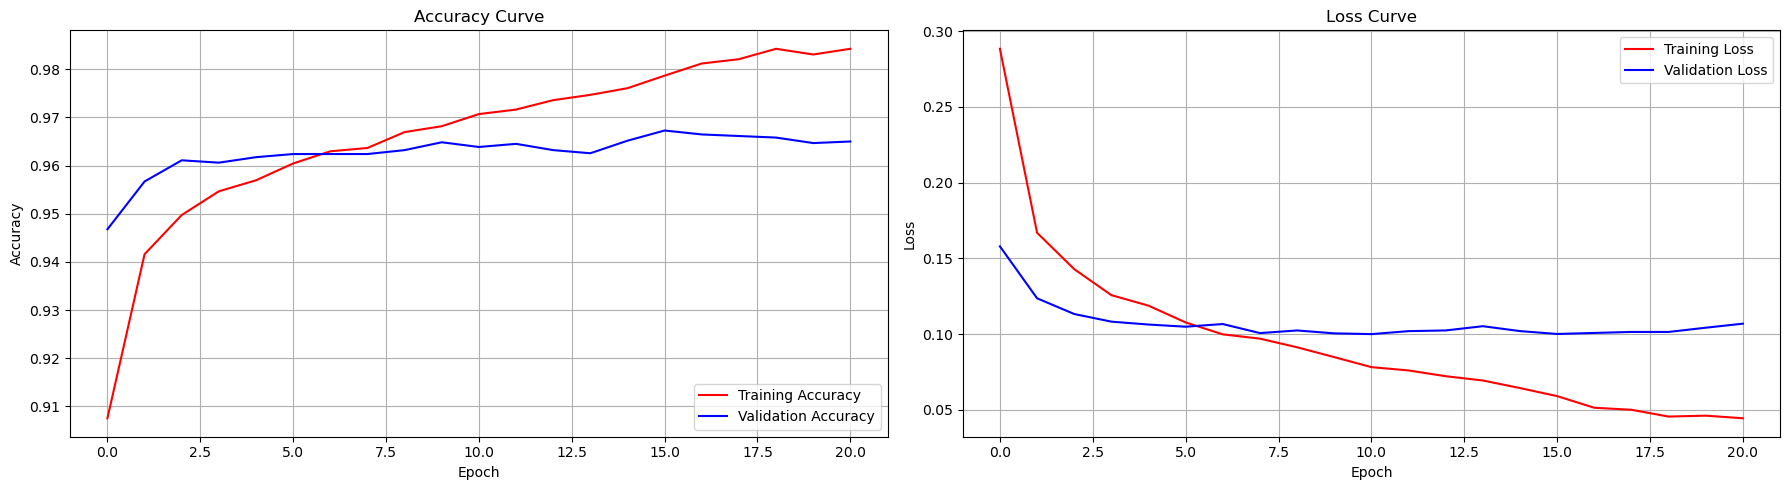

In [18]:
plot_loss_accuracy(multi_cnn_history)

In [19]:
y_train_pred_multi= multi_cnn_model.predict(X_train)
y_train_pred_multi = y_train_pred_multi.argmax(axis=-1)

y_test_pred_multi = multi_cnn_model.predict(X_test)
y_test_pred_multi = y_test_pred_multi.argmax(axis=-1)

240/240 [==============================] - 3s 13ms/step


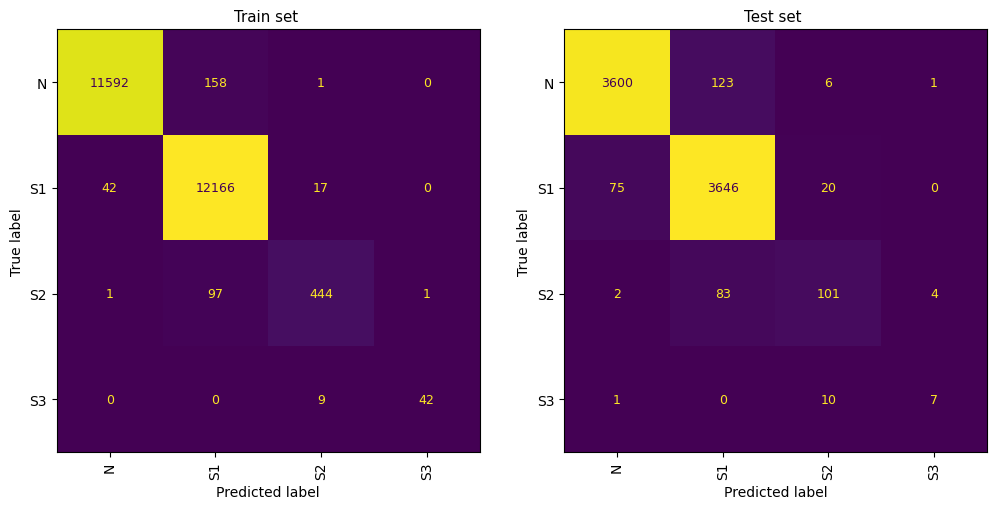

In [20]:
class_names=['N','S1','S2','S3']
print_conf_matrix(y_train, y_train_pred_multi, y_test, y_test_pred_multi, class_names)

### CNN+LSTM

In [21]:
multi_cnn_lstm, multi_cnn_lstm_history = create_fit_cnn_lstm(32, 3, 'relu', 'glorot_normal', 0.001, 0.3)
multi_cnn_lstm.save("multi_cnn_lstm", save_format="tf")

2023-10-05 07:20:33.889025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 07:20:33.889972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 07:20:33.891032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-10-05 07:20:34.313677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 07:20:34.314856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 07:20:34.316018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

768/768 [==============================] - ETA: 0s - loss: 0.5649 - accuracy: 0.8041

2023-10-05 07:21:10.057440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 07:21:10.058702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 07:21:10.060341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

768/768 [==============================] - 39s 48ms/step - loss: 0.5649 - accuracy: 0.8041 - val_loss: 0.4079 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 36s 47ms/step - loss: 0.4229 - accuracy: 0.8346 - val_loss: 0.3668 - val_accuracy: 0.8541 - lr: 0.0010
Epoch 3/100
768/768 [==============================] - 39s 50ms/step - loss: 0.3864 - accuracy: 0.8469 - val_loss: 0.3369 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 4/100
768/768 [==============================] - 37s 48ms/step - loss: 0.3656 - accuracy: 0.8516 - val_loss: 0.3359 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 37s 48ms/step - loss: 0.3440 - accuracy: 0.8583 - val_loss: 0.3372 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 35s 45ms/step - loss: 0.3239 - accuracy: 0.8687 - val_loss: 0.3738 - val_accuracy: 0.8541 - lr: 0.0010
Epoch 7/100
768/768 [==============================] - 37s 48ms/

2023-10-05 07:50:49.470066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 07:50:49.471224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 07:50:49.472571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-10-05 07:50:50.554905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 07:50:50.555827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 07:50:50.556699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-10-05 07:50:51.840813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 07:50:51.841903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 07:50:51.843017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-10-05 07:50:53.104273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 07:50:53.105393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 07:50:53.106653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: multi_cnn_lstm/assets


INFO:tensorflow:Assets written to: multi_cnn_lstm/assets


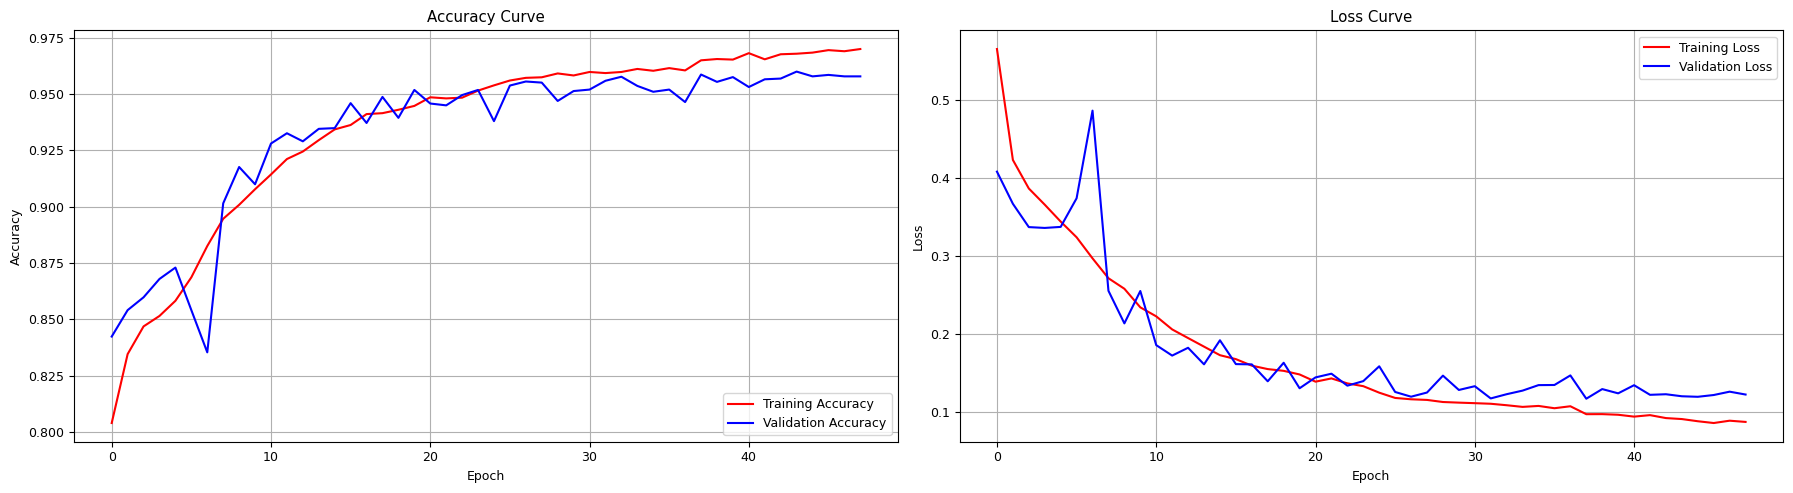

In [22]:
plot_loss_accuracy(multi_cnn_lstm_history)

In [23]:
y_train_pred_multi_lstm= multi_cnn_lstm.predict(X_train)
y_train_pred_multi_lstm = y_train_pred_multi_lstm.argmax(axis=-1)

y_test_pred_multi_lstm = multi_cnn_lstm.predict(X_test)
y_test_pred_multi_lstm = y_test_pred_multi_lstm.argmax(axis=-1)

2023-10-05 07:50:54.980296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 07:50:54.981502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 07:50:54.982643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

240/240 [==============================] - 4s 15ms/step


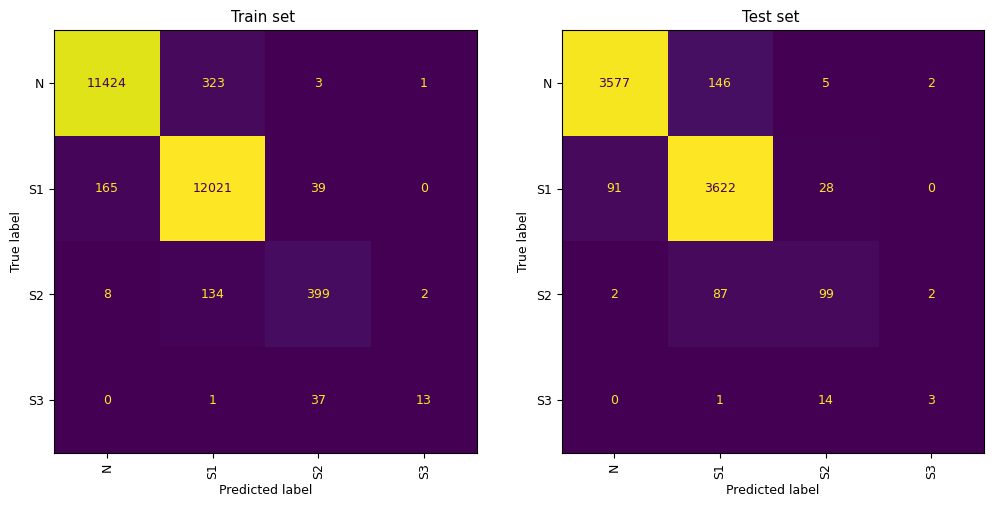

In [24]:
class_names=['N','S1','S2','S3']
print_conf_matrix(y_train, y_train_pred_multi_lstm, y_test, y_test_pred_multi_lstm, class_names)

## Binary Classification

In [25]:
no_class=2
X_train, X_test, X_val, y_train, y_test, y_val = split_data(no_class,X,y)

In [26]:
X_train.shape

(24570, 62, 13)

### CNN Only

In [27]:
bin_cnn_model, bin_cnn_history = create_fit_cnn(32, 3, 'relu', 'glorot_normal', 0.001, 0.3)
bin_cnn_model.save("bin_cnn_model", save_format="tf")

Epoch 1/100
768/768 [==============================] - 28s 36ms/step - loss: 0.1626 - accuracy: 0.9345 - val_loss: 0.0940 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 27s 36ms/step - loss: 0.1003 - accuracy: 0.9626 - val_loss: 0.0989 - val_accuracy: 0.9604 - lr: 0.0010
Epoch 3/100
768/768 [==============================] - 27s 35ms/step - loss: 0.0898 - accuracy: 0.9653 - val_loss: 0.0710 - val_accuracy: 0.9718 - lr: 0.0010
Epoch 4/100
768/768 [==============================] - 28s 37ms/step - loss: 0.0829 - accuracy: 0.9682 - val_loss: 0.0759 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 27s 36ms/step - loss: 0.0764 - accuracy: 0.9710 - val_loss: 0.0732 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 30s 39ms/step - loss: 0.0731 - accuracy: 0.9734 - val_loss: 0.0717 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 7/100
768/768 [==============================]

2023-10-05 08:01:14.698557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]
2023-10-05 08:01:14.972697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: bin_cnn_model/assets


INFO:tensorflow:Assets written to: bin_cnn_model/assets


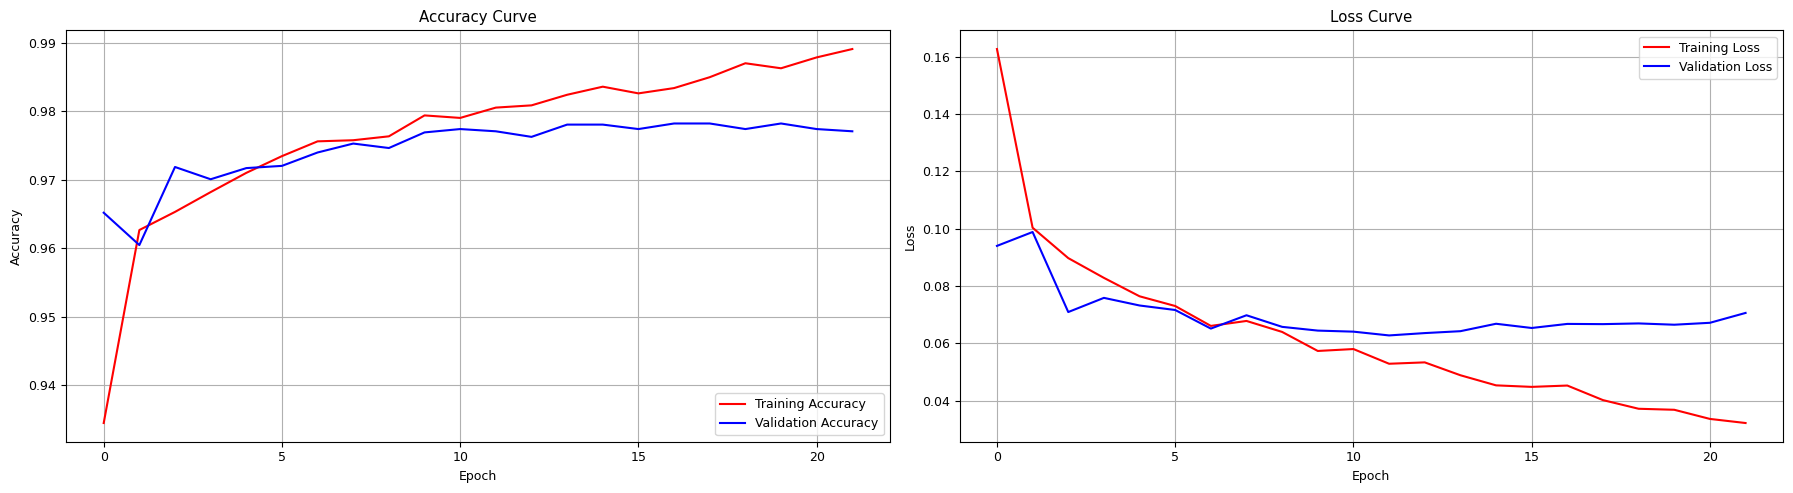

In [28]:
plot_loss_accuracy(bin_cnn_history)

In [29]:
y_train_pred_bin = bin_cnn_model.predict(X_train)
y_test_pred_bin = bin_cnn_model.predict(X_test)

y_train_pred_bin = (y_train_pred_bin >= 0.5).astype(int)
y_test_pred_bin = (y_test_pred_bin >= 0.5).astype(int)

240/240 [==============================] - 3s 14ms/step


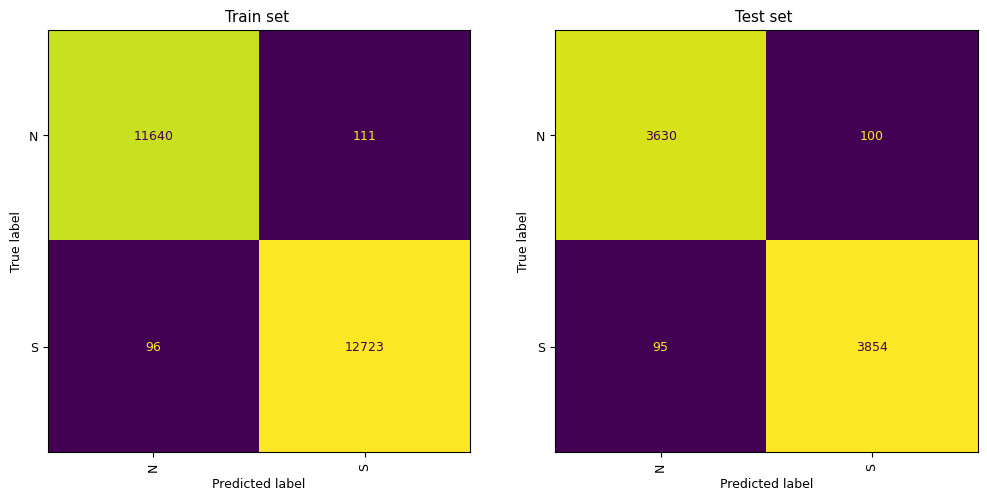

In [30]:
class_names=['N','S']
print_conf_matrix(y_train, y_train_pred_bin, y_test, y_test_pred_bin, class_names)

### CNN + LSTM

In [31]:
bin_cnn_lstm, bin_cnn_lstm_history = create_fit_cnn(32, 3, 'relu', 'glorot_normal', 0.001, 0.3)
bin_cnn_lstm.save("bin_cnn_lstm", save_format="tf")

Epoch 1/100
768/768 [==============================] - 30s 38ms/step - loss: 0.1627 - accuracy: 0.9344 - val_loss: 0.1013 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 29s 37ms/step - loss: 0.1043 - accuracy: 0.9593 - val_loss: 0.0863 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 3/100
768/768 [==============================] - 26s 34ms/step - loss: 0.0881 - accuracy: 0.9653 - val_loss: 0.0757 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 4/100
768/768 [==============================] - 26s 34ms/step - loss: 0.0827 - accuracy: 0.9691 - val_loss: 0.0731 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 28s 36ms/step - loss: 0.0759 - accuracy: 0.9721 - val_loss: 0.0692 - val_accuracy: 0.9754 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 28s 37ms/step - loss: 0.0722 - accuracy: 0.9728 - val_loss: 0.0738 - val_accuracy: 0.9751 - lr: 0.0010
Epoch 7/100
768/768 [==============================]

2023-10-05 08:14:08.190207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]
2023-10-05 08:14:08.451230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: bin_cnn_lstm/assets


INFO:tensorflow:Assets written to: bin_cnn_lstm/assets


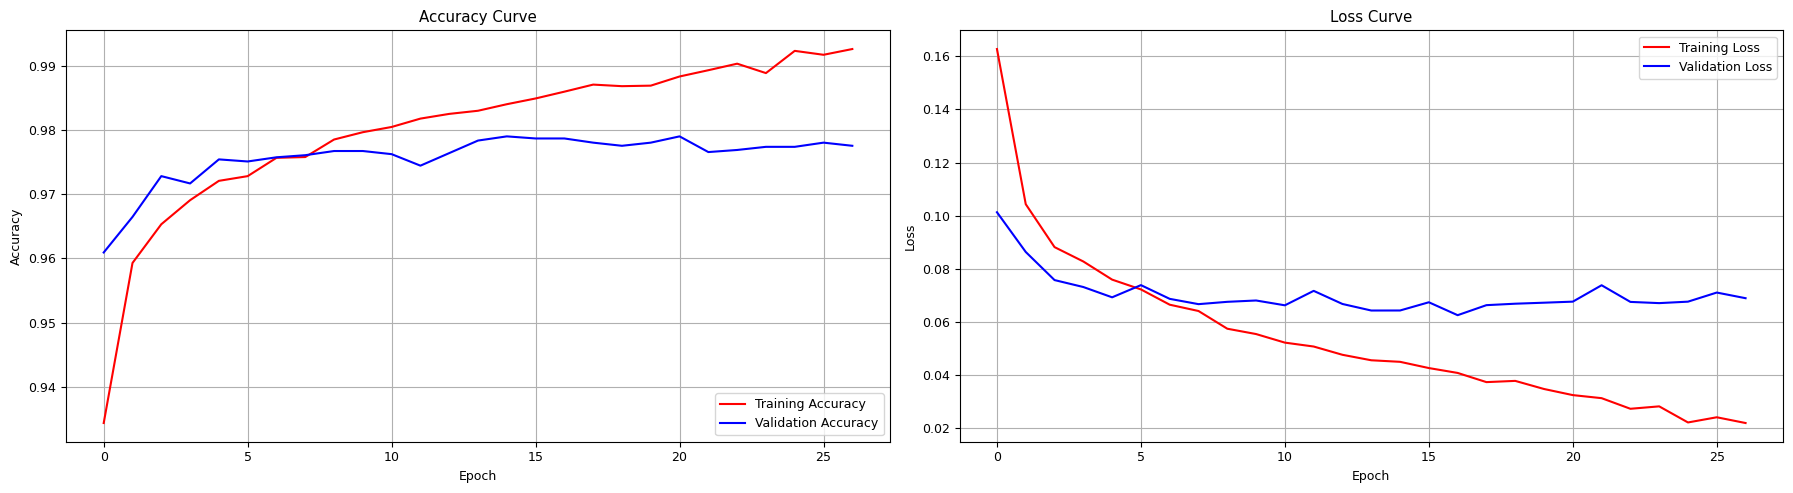

In [32]:
plot_loss_accuracy(bin_cnn_lstm_history)

In [33]:
y_train_pred_bin_lstm = bin_cnn_lstm.predict(X_train)
y_test_pred_bin_lstm = bin_cnn_lstm.predict(X_test)
y_train_pred_bin_lstm = (y_train_pred_bin_lstm >= 0.5).astype(int)
y_test_pred_bin_lstm = (y_test_pred_bin_lstm >= 0.5).astype(int)

240/240 [==============================] - 3s 13ms/step


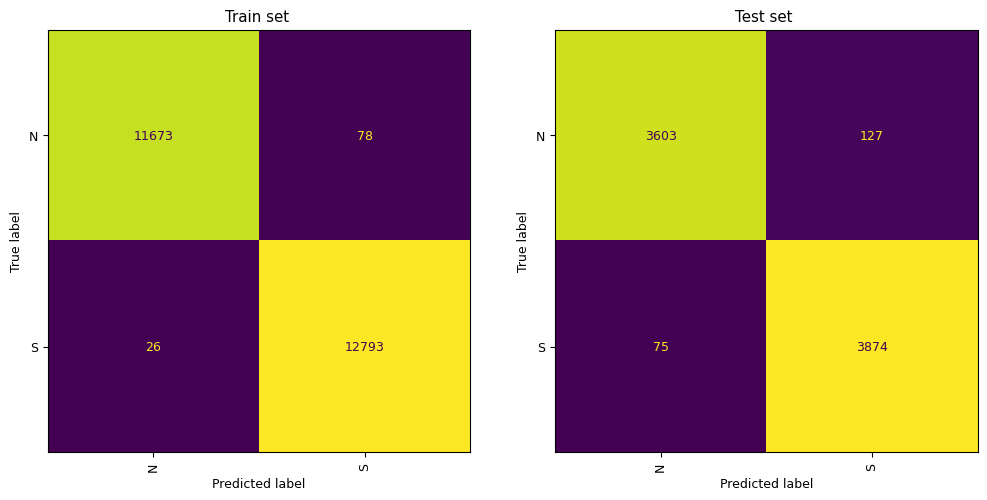

In [34]:
class_names=['N','S']
print_conf_matrix(y_train, y_train_pred_bin_lstm, y_test, y_test_pred_bin_lstm, class_names)

## Model Comparision

In [35]:
from sklearn.metrics import accuracy_score, f1_score
def cal_scores (y_true, y_pred):
    return  f1_score(y_true,y_pred, average="macro"), accuracy_score(y_true,y_pred)

In [36]:
train_f1_multi, train_accuracy_multi = cal_scores(y_train, y_train_pred_multi)
test_f1_multi, test_accuracy_multi = cal_scores(y_test, y_test_pred_multi)

In [37]:
train_f1_multi_lstm, train_accuracy_multi_lstm = cal_scores(y_train, y_train_pred_multi_lstm)
test_f1_multi_lstm, test_accuracy_multi_lstm = cal_scores(y_test, y_test_pred_multi_lstm)

In [38]:
train_f1_bin, train_accuracy_bin = cal_scores(y_train, y_train_pred_bin)
test_f1_bin, test_accuracy_bin = cal_scores(y_test, y_test_pred_bin)

In [39]:
train_f1_bin_lstm, train_accuracy_bin_lstm = cal_scores(y_train, y_train_pred_bin_lstm)
test_f1_bin_lstm, test_accuracy_bin_lstm = cal_scores(y_test, y_test_pred_bin_lstm)

### Comparing Accuracies

In [49]:
print("Accuracy Comparision")
accuracy_metrics = {
    "Data Set": ["Accuracy-Multiclass_CNN", "Accuracy-Multiclass_CNN+LSTM", "Accuracy-Binary_CNN", "Accuracy-Binary_CNN+LSTM"],
    "Training Set": [f"{train_accuracy_multi:.2%}", f"{train_accuracy_multi_lstm:.2%}", f"{train_accuracy_bin:.2%}", f"{train_accuracy_bin_lstm:.2%}"],
    "Test Set": [f"{test_accuracy_multi:.2%}", f"{test_accuracy_multi_lstm:.2%}",f"{test_accuracy_bin:.2%}", f"{test_accuracy_bin_lstm:.2%}"]}
accuracy_metrics_df = pd.DataFrame(accuracy_metrics)
accuracy_metrics_df = accuracy_metrics_df.transpose()
accuracy_metrics_df

Accuracy Comparision


,0,1,2,3
Data Set,Accuracy-Multiclass_CNN,Accuracy-Multiclass_CNN+LSTM,Accuracy-Binary_CNN,Accuracy-Binary_CNN+LSTM
Training Set,97.09%,95.97%,99.16%,99.58%
Test Set,95.44%,94.90%,97.46%,97.37%


### Comparing F1 Scores

In [48]:
print("F1 Score Comparision")
f1_metrics = {
    "Data Set": ["F1 Score-Multiclass_CNN", "F1 Score-Multiclass_CNN+LSTM", "F1 Score-Binary_CNN", "F1 Score-Binary_CNN+lstm"],
    "Training Set": [f"{train_f1_multi:.2%}", f"{train_f1_multi_lstm:.2%}", f"{train_f1_bin:.2%}", f"{train_f1_bin_lstm:.2%}"],
    "Test Set": [f"{test_f1_multi:.2%}", f"{test_f1_multi_lstm:.2%}",f"{test_f1_bin:.2%}", f"{test_f1_bin_lstm:.2%}"]}
f1_metrics_df = pd.DataFrame(f1_metrics)
f1_metrics_df = f1_metrics_df.transpose()
f1_metrics_df

F1 Score Comparision


,0,1,2,3
Data Set,F1 Score-Multiclass_CNN,F1 Score-Multiclass_CNN+LSTM,F1 Score-Binary_CNN,F1 Score-Binary_CNN+lstm
Training Set,49.08%,48.49%,99.16%,99.58%
Test Set,48.20%,47.94%,97.46%,97.37%
